In [1]:
from unityagents import UnityEnvironment
env_file = "Tennis_Windows_x86_64\Tennis.exe" #'Tennis_Linux/Tennis.x86_64'#
env = UnityEnvironment(file_name=env_file, no_graphics = True)

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


In [2]:
import torch
import numpy as np
from collections import deque
import progressbar as pb
import matplotlib.pyplot as plt
from utils import OUprocess, Reply_buffer
from Tennis_agent import SelfPlay_Agent

using device:  cpu
NO grad. clipping used.


In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('states shape: ',states.shape)
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])
print('The state for the second agent looks like:', states[1])

Number of agents: 2
Size of each action: 2
states shape:  (2, 24)
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]
The state for the second agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.4669857  -1.5
  0.          0.         -6.83172083  6.          0.          0.        ]


In [4]:
T_max = 1000
max_buffer = int(1.e+6)
buffer = Reply_buffer(max_buffer)
noise_decay = 1#0.999
noise_lvl = 0.2
ouA = OUprocess(action_size, sigma=noise_lvl)
ouB = OUprocess(action_size, sigma=noise_lvl)
batch_size = 256
update_steps = 5  #with (128,5,10,5e-4,5e-4) -> 0.23 @ 600 episodes
GD_steps = 4 #with (256,5,4,1e-3,1e-3) -> 0.44 @ 800 episodes
lra=3.e-3
lrc=3.e-3
agent = SelfPlay_Agent(state_size, action_size, num_agents, tau=1, lr_act=lra, lr_crit=lrc)

nr_episodes = 1200

In [5]:

widget = ['training loop: ', pb.Percentage(), ' ', pb.Bar()]#, ' ', pb.ETA() ]
timer = pb.ProgressBar(widgets=widget, maxval=nr_episodes).start()
min_buffer = num_agents*batch_size
assert min_buffer<max_buffer, 'minimal length of buffer for update (min_buffer) smaller than buffer memory (max_buffer)!'
ACloss = []
l_exists = False
e_score = np.zeros(nr_episodes)
rolling_avg = np.zeros(nr_episodes)
rolling_window = deque(maxlen=100)
t=0
for i in range(nr_episodes):                                         # play game for nr_episodes episodes
    env_info = env.reset(train_mode=True)[brain_name]     # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    ouA.reset()
    ouB.reset()
    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
    while True:#t<T_max:
        t+=1
        # select action
        agent.actor.eval()
        actA  = agent.act(states[np.newaxis,0]).data.cpu().numpy() + ouA.noise()
        actB = agent.act(states[np.newaxis,1]).data.cpu().numpy() + ouB.noise()
        actions = np.clip([actA[0], actB[0]],-1,1) # select an action (for each agent)
        # execute and observe
        #actions = [np.array([0.1,1]),np.array([0.1,1])]
        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        # store in replay buffer
        samples = [states, np.asarray(actions), np.asarray(rewards), next_states, dones]
        buffer.store(samples)
        # roll over states to next time step
        states = next_states                               
        # keep track of scores
        scores += env_info.rewards                         # update the score (for each agent)
        # Update agents
        if ((t-1) % update_steps == 0) and len(buffer.buffer) > batch_size:
            l_exists = True
            agent.actor.train()
            #for a_i in np.random.permutation(num_agents): #ideally you would like to sample the agents randomly 
            for ep in range(GD_steps):
                minibatch = buffer.get_batch(batch_size)  # get batch of size (batch_size x 5) where the 2nd dim corresponds to (s,a,r,s',done)
                agent_i = np.random.choice(num_agents,len(minibatch))
                closs = agent.update_critic(minibatch,agent_i)
                aloss = agent.update_actor(minibatch,agent_i)
            #ACloss.append([aloss,closs])
                    
        # Update target network
        if agent.tau == 1 and t% int(2*update_steps) == 0:
            agent.target_update()
        else:
            agent.target_update()
        # exit loop if episode finished
        if np.any(dones): 
            break
    
    if l_exists:
        ACloss.append([aloss,closs])

    ouA.sigma *= noise_decay
    ouB.sigma *= noise_decay
    
    e_score[i] = np.max(scores)
    rolling_window.append(e_score[i])
    rolling_avg[i] = np.mean(np.array(rolling_window))
    if (i+1) % 20 == 0:
        print('Total score (averaged over agents) episode {}: {}'.format(i+1,np.mean(scores)))
        print('Score (max over agents) from episode {}: {}'.format(i+1, e_score[i]))
        print('Rolling average score: {}'.format(rolling_avg[i]))
        print('Noise level: ',ouA.sigma,ouB.sigma)
        if l_exists:
            print("Actor loss: {} | Critic loss: {}".format(*ACloss[-1]))
    
    # update progress widget bar
    timer.update(i+1)
    
timer.finish()

Total score (averaged over agents) episode 20: -0.004999999888241291
Score (max over agents) from episode 20: 0.0
Rolling average score: 0.0
Noise level:  0.2 0.2
Actor loss: 0.03944665566086769 | Critic loss: 0.0001117241190513596


Total score (averaged over agents) episode 40: -0.004999999888241291
Score (max over agents) from episode 40: 0.0
Rolling average score: 0.0022500000428408383
Noise level:  0.2 0.2
Actor loss: 0.00025725935120135546 | Critic loss: 2.8071150154573843e-05


Total score (averaged over agents) episode 60: -0.004999999888241291
Score (max over agents) from episode 60: 0.0
Rolling average score: 0.006166666777183612
Noise level:  0.2 0.2
Actor loss: 0.0012401251588016748 | Critic loss: 2.004933776333928e-05


Total score (averaged over agents) episode 80: 0.04500000085681677
Score (max over agents) from episode 80: 0.10000000149011612
Rolling average score: 0.010625000181607901
Noise level:  0.2 0.2
Actor loss: -0.004137566313147545 | Critic loss: 4.158737283432856e-05


Total score (averaged over agents) episode 100: -0.004999999888241291
Score (max over agents) from episode 100: 0.0
Rolling average score: 0.009400000162422657
Noise level:  0.2 0.2
Actor loss: -0.016995370388031006 | Critic loss: 0.00011927062587346882


Total score (averaged over agents) episode 120: -0.004999999888241291
Score (max over agents) from episode 120: 0.0
Rolling average score: 0.020100000333040952
Noise level:  0.2 0.2
Actor loss: -0.01457118708640337 | Critic loss: 7.651789201190695e-05


Total score (averaged over agents) episode 140: 0.04500000085681677
Score (max over agents) from episode 140: 0.10000000149011612
Rolling average score: 0.025800000429153442
Noise level:  0.2 0.2
Actor loss: -0.00830402784049511 | Critic loss: 8.62777087604627e-05


Total score (averaged over agents) episode 160: -0.004999999888241291
Score (max over agents) from episode 160: 0.0
Rolling average score: 0.024900000412017106
Noise level:  0.2 0.2
Actor loss: -0.014501395635306835 | Critic loss: 7.192746124928817e-05


Total score (averaged over agents) episode 180: -0.004999999888241291
Score (max over agents) from episode 180: 0.0
Rolling average score: 0.020100000333040952
Noise level:  0.2 0.2
Actor loss: -0.007516906596720219 | Critic loss: 7.176194048952311e-05


Total score (averaged over agents) episode 200: -0.004999999888241291
Score (max over agents) from episode 200: 0.0
Rolling average score: 0.029000000469386576
Noise level:  0.2 0.2
Actor loss: -0.02053249627351761 | Critic loss: 0.0001221338752657175


Total score (averaged over agents) episode 220: -0.004999999888241291
Score (max over agents) from episode 220: 0.0
Rolling average score: 0.03500000055879354
Noise level:  0.2 0.2
Actor loss: -0.0420016311109066 | Critic loss: 0.00024379478418268263


Total score (averaged over agents) episode 240: -0.004999999888241291
Score (max over agents) from episode 240: 0.0
Rolling average score: 0.040200000628829
Noise level:  0.2 0.2
Actor loss: -0.03596439212560654 | Critic loss: 0.00013765081530436873


Total score (averaged over agents) episode 260: 0.04500000085681677
Score (max over agents) from episode 260: 0.10000000149011612
Rolling average score: 0.05190000081434846
Noise level:  0.2 0.2
Actor loss: -0.03148367255926132 | Critic loss: 0.00010129783186130226


Total score (averaged over agents) episode 280: 0.04500000085681677
Score (max over agents) from episode 280: 0.10000000149011612
Rolling average score: 0.07090000113472343
Noise level:  0.2 0.2
Actor loss: -0.04737410694360733 | Critic loss: 0.00011718257883330807


Total score (averaged over agents) episode 300: 0.04500000085681677
Score (max over agents) from episode 300: 0.10000000149011612
Rolling average score: 0.07870000125840307
Noise level:  0.2 0.2
Actor loss: -0.04430166631937027 | Critic loss: 0.00011474888742668554


Total score (averaged over agents) episode 320: 0.09500000160187483
Score (max over agents) from episode 320: 0.10000000149011612
Rolling average score: 0.08130000131204725
Noise level:  0.2 0.2
Actor loss: -0.05139379948377609 | Critic loss: 0.0002011981705436483


Total score (averaged over agents) episode 340: 0.04500000085681677
Score (max over agents) from episode 340: 0.10000000149011612
Rolling average score: 0.08790000142529607
Noise level:  0.2 0.2
Actor loss: -0.03885119780898094 | Critic loss: 0.00013738380221184343


Total score (averaged over agents) episode 360: 0.04500000085681677
Score (max over agents) from episode 360: 0.10000000149011612
Rolling average score: 0.09170000148937106
Noise level:  0.2 0.2
Actor loss: -0.03797643631696701 | Critic loss: 8.407323912251741e-05


Total score (averaged over agents) episode 380: 0.245000003837049
Score (max over agents) from episode 380: 0.2900000046938658
Rolling average score: 0.09620000153779984
Noise level:  0.2 0.2
Actor loss: -0.03355477750301361 | Critic loss: 0.00018611866107676178


Total score (averaged over agents) episode 400: 0.09500000160187483
Score (max over agents) from episode 400: 0.10000000149011612
Rolling average score: 0.10480000168085098
Noise level:  0.2 0.2
Actor loss: -0.04667658358812332 | Critic loss: 0.00020061203395016491


Total score (averaged over agents) episode 420: 0.6450000097975135
Score (max over agents) from episode 420: 0.7000000104308128
Rolling average score: 0.12350000193342567
Noise level:  0.2 0.2
Actor loss: -0.06386715918779373 | Critic loss: 0.0002963786537293345


Total score (averaged over agents) episode 440: 0.19500000309199095
Score (max over agents) from episode 440: 0.20000000298023224
Rolling average score: 0.14190000219270588
Noise level:  0.2 0.2
Actor loss: -0.07311342656612396 | Critic loss: 0.0002697597665246576


Total score (averaged over agents) episode 460: 0.4950000075623393
Score (max over agents) from episode 460: 0.5000000074505806
Rolling average score: 0.17520000267773866
Noise level:  0.2 0.2
Actor loss: -0.08427155762910843 | Critic loss: 0.00021722537348978221


Total score (averaged over agents) episode 480: -0.004999999888241291
Score (max over agents) from episode 480: 0.0
Rolling average score: 0.1884000028669834
Noise level:  0.2 0.2
Actor loss: -0.08020435273647308 | Critic loss: 0.00022351916413754225


Total score (averaged over agents) episode 500: 0.29500000458210707
Score (max over agents) from episode 500: 0.30000000447034836
Rolling average score: 0.18900000285357238
Noise level:  0.2 0.2
Actor loss: -0.084547258913517 | Critic loss: 0.00020875065820291638


Total score (averaged over agents) episode 520: 0.04500000085681677
Score (max over agents) from episode 520: 0.10000000149011612
Rolling average score: 0.21090000318363308
Noise level:  0.2 0.2
Actor loss: -0.09908083081245422 | Critic loss: 0.00026844703825190663


Total score (averaged over agents) episode 540: 0.3450000053271651
Score (max over agents) from episode 540: 0.4000000059604645
Rolling average score: 0.23050000349059702
Noise level:  0.2 0.2
Actor loss: -0.10442500561475754 | Critic loss: 0.0002711365814320743


Total score (averaged over agents) episode 560: 0.09500000160187483
Score (max over agents) from episode 560: 0.10000000149011612
Rolling average score: 0.22560000341385603
Noise level:  0.2 0.2
Actor loss: -0.11625920981168747 | Critic loss: 0.0003003115707542747


Total score (averaged over agents) episode 580: 0.09500000160187483
Score (max over agents) from episode 580: 0.10000000149011612
Rolling average score: 0.2067000031284988
Noise level:  0.2 0.2
Actor loss: -0.11592148244380951 | Critic loss: 0.00030256417812779546


Total score (averaged over agents) episode 600: 0.19500000309199095
Score (max over agents) from episode 600: 0.20000000298023224
Rolling average score: 0.23460000354796648
Noise level:  0.2 0.2
Actor loss: -0.12021049857139587 | Critic loss: 0.00029227431514300406


Total score (averaged over agents) episode 620: 0.04500000085681677
Score (max over agents) from episode 620: 0.10000000149011612
Rolling average score: 0.25070000378414986
Noise level:  0.2 0.2
Actor loss: -0.1314949095249176 | Critic loss: 0.0004551848105620593


Total score (averaged over agents) episode 640: -0.004999999888241291
Score (max over agents) from episode 640: 0.0
Rolling average score: 0.2801000042073429
Noise level:  0.2 0.2
Actor loss: -0.12565071880817413 | Critic loss: 0.0006201795185916126


Total score (averaged over agents) episode 660: 0.09500000160187483
Score (max over agents) from episode 660: 0.10000000149011612
Rolling average score: 0.25230000378564
Noise level:  0.2 0.2
Actor loss: -0.13035117089748383 | Critic loss: 0.00035916490014642477


Total score (averaged over agents) episode 680: 0.09500000160187483
Score (max over agents) from episode 680: 0.10000000149011612
Rolling average score: 0.315400004722178
Noise level:  0.2 0.2
Actor loss: -0.13700249791145325 | Critic loss: 0.0002821945818141103


Total score (averaged over agents) episode 700: 0.04500000085681677
Score (max over agents) from episode 700: 0.10000000149011612
Rolling average score: 0.31530000472441316
Noise level:  0.2 0.2
Actor loss: -0.16438257694244385 | Critic loss: 0.00042281363857910037


Total score (averaged over agents) episode 720: 0.09500000160187483
Score (max over agents) from episode 720: 0.10000000149011612
Rolling average score: 0.3050000045821071
Noise level:  0.2 0.2
Actor loss: -0.13851584494113922 | Critic loss: 0.00035180250415578485


Total score (averaged over agents) episode 740: 1.145000017248094
Score (max over agents) from episode 740: 1.2000000178813934
Rolling average score: 0.31600000474601986
Noise level:  0.2 0.2
Actor loss: -0.16457900404930115 | Critic loss: 0.00041653186781331897


Total score (averaged over agents) episode 760: 0.04500000085681677
Score (max over agents) from episode 760: 0.10000000149011612
Rolling average score: 0.354500005338341
Noise level:  0.2 0.2
Actor loss: -0.16545981168746948 | Critic loss: 0.00043701654067263007


Total score (averaged over agents) episode 780: 0.29500000458210707
Score (max over agents) from episode 780: 0.30000000447034836
Rolling average score: 0.3704000055789948
Noise level:  0.2 0.2
Actor loss: -0.14052553474903107 | Critic loss: 0.0003811375645454973


Total score (averaged over agents) episode 800: 0.04500000085681677
Score (max over agents) from episode 800: 0.10000000149011612
Rolling average score: 0.35550000535324217
Noise level:  0.2 0.2
Actor loss: -0.17425058782100677 | Critic loss: 0.0004952250747010112


Total score (averaged over agents) episode 820: 1.5450000232085586
Score (max over agents) from episode 820: 1.600000023841858
Rolling average score: 0.35850000539794563
Noise level:  0.2 0.2
Actor loss: -0.17037412524223328 | Critic loss: 0.00038237107219174504


Total score (averaged over agents) episode 840: 0.04500000085681677
Score (max over agents) from episode 840: 0.10000000149011612
Rolling average score: 0.3315000049956143
Noise level:  0.2 0.2
Actor loss: -0.17550043761730194 | Critic loss: 0.0002486685407347977


Total score (averaged over agents) episode 860: 0.44500000681728125
Score (max over agents) from episode 860: 0.5000000074505806
Rolling average score: 0.3338000050187111
Noise level:  0.2 0.2
Actor loss: -0.16819459199905396 | Critic loss: 0.00033797055948525667


Total score (averaged over agents) episode 880: 0.19500000309199095
Score (max over agents) from episode 880: 0.20000000298023224
Rolling average score: 0.3237000048719347
Noise level:  0.2 0.2
Actor loss: -0.1859704554080963 | Critic loss: 0.00027659733314067125


Total score (averaged over agents) episode 900: 1.2450000187382102
Score (max over agents) from episode 900: 1.290000019595027
Rolling average score: 0.36270000545307995
Noise level:  0.2 0.2
Actor loss: -0.1625099778175354 | Critic loss: 0.0003593800647649914


Total score (averaged over agents) episode 920: 0.29500000458210707
Score (max over agents) from episode 920: 0.30000000447034836
Rolling average score: 0.4288000064343214
Noise level:  0.2 0.2
Actor loss: -0.18972064554691315 | Critic loss: 0.0004110183217562735


Total score (averaged over agents) episode 940: 0.245000003837049
Score (max over agents) from episode 940: 0.2900000046938658
Rolling average score: 0.4368000065535307
Noise level:  0.2 0.2
Actor loss: -0.19277524948120117 | Critic loss: 0.00033060077112168074


Total score (averaged over agents) episode 960: 0.09500000160187483
Score (max over agents) from episode 960: 0.10000000149011612
Rolling average score: 0.47800000716000796
Noise level:  0.2 0.2
Actor loss: -0.18547353148460388 | Critic loss: 0.0003937282017432153


Total score (averaged over agents) episode 980: 1.045000015757978
Score (max over agents) from episode 980: 1.1000000163912773
Rolling average score: 0.47220000706613063
Noise level:  0.2 0.2
Actor loss: -0.18325674533843994 | Critic loss: 0.0005491498159244657


Total score (averaged over agents) episode 1000: 0.09500000160187483
Score (max over agents) from episode 1000: 0.10000000149011612
Rolling average score: 0.44540000665932894
Noise level:  0.2 0.2
Actor loss: -0.19607973098754883 | Critic loss: 0.00034292455529794097


Total score (averaged over agents) episode 1020: 0.04500000085681677
Score (max over agents) from episode 1020: 0.10000000149011612
Rolling average score: 0.3825000057183206
Noise level:  0.2 0.2
Actor loss: -0.1820012331008911 | Critic loss: 0.00027267145924270153


Total score (averaged over agents) episode 1040: 0.09500000160187483
Score (max over agents) from episode 1040: 0.10000000149011612
Rolling average score: 0.3405000051110983
Noise level:  0.2 0.2
Actor loss: -0.17865170538425446 | Critic loss: 0.0005985886673443019


Total score (averaged over agents) episode 1060: 0.7950000120326877
Score (max over agents) from episode 1060: 0.800000011920929
Rolling average score: 0.2900000043772161
Noise level:  0.2 0.2
Actor loss: -0.17995105683803558 | Critic loss: 0.0002907932212110609


Total score (averaged over agents) episode 1080: 0.4950000075623393
Score (max over agents) from episode 1080: 0.5000000074505806
Rolling average score: 0.3057000046223402
Noise level:  0.2 0.2
Actor loss: -0.18619056046009064 | Critic loss: 0.0003830206114798784


Total score (averaged over agents) episode 1100: 0.1450000023469329
Score (max over agents) from episode 1100: 0.20000000298023224
Rolling average score: 0.3325000050291419
Noise level:  0.2 0.2
Actor loss: -0.21060800552368164 | Critic loss: 0.000483419222291559


Total score (averaged over agents) episode 1120: 0.09500000160187483
Score (max over agents) from episode 1120: 0.10000000149011612
Rolling average score: 0.3546000053547323
Noise level:  0.2 0.2
Actor loss: -0.21464687585830688 | Critic loss: 0.0005458879168145359


Total score (averaged over agents) episode 1140: 0.19500000309199095
Score (max over agents) from episode 1140: 0.20000000298023224
Rolling average score: 0.4077000061236322
Noise level:  0.2 0.2
Actor loss: -0.20290127396583557 | Critic loss: 0.0004250119091011584


Total score (averaged over agents) episode 1160: 0.1450000023469329
Score (max over agents) from episode 1160: 0.20000000298023224
Rolling average score: 0.4611000069230795
Noise level:  0.2 0.2
Actor loss: -0.21081842482089996 | Critic loss: 0.00045721285277977586


Total score (averaged over agents) episode 1180: 0.04500000085681677
Score (max over agents) from episode 1180: 0.10000000149011612
Rolling average score: 0.46620000699535014
Noise level:  0.2 0.2
Actor loss: -0.22715260088443756 | Critic loss: 0.0004124463303014636


Total score (averaged over agents) episode 1200: 0.5950000090524554
Score (max over agents) from episode 1200: 0.6000000089406967
Rolling average score: 0.4355000065267086
Noise level:  0.2 0.2
Actor loss: -0.20389442145824432 | Critic loss: 0.0002737015311140567


In [6]:
dones[1] = True
print(dones,sum(dones))
print(actA)
print(actB)

[True, True] 2
[[0.2156305  0.91295623]]
[[ 1.39389414 -0.63960684]]


(1182, 2)


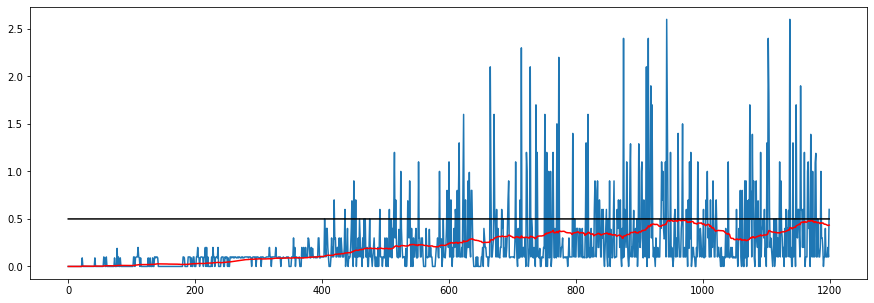

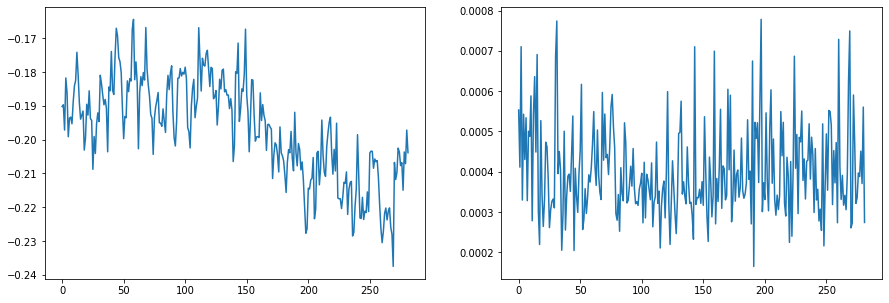

In [15]:
ACloss = np.asarray(ACloss)
print(ACloss.shape)
plt.figure(figsize=(15,5))
plt.plot(e_score)
plt.plot(rolling_avg,'r')
plt.plot(0.5*np.ones_like(rolling_avg),'k')
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.plot(ACloss[:,0])
plt.subplot(122)
plt.plot(ACloss[:,1])


In [8]:
# env.close()
print('lra {}, lrc {}, noise_lvl {}, noise_decay {}, batch_size {}, update_steps {}, GD_steps {}'.format(lra, lrc, noise_lvl,noise_decay,batch_size,
                                                                                         update_steps,GD_steps))

lra 0.003, lrc 0.003, noise_lvl 0.2, noise_decay 1, batch_size 256, update_steps 5, GD_steps 4


In [9]:
len(buffer.buffer)

115421

In [10]:
print(t)

115421


In [11]:
for param_grp in agent.actor_optim.param_groups:
    print(param_grp['lr'])
for param_grp in agent.critic_optim.param_groups:
    print(param_grp['lr'])
print(agent.actor)
print(agent.critic)

0.003
0.003
ActorNet(
  (fc_in): Linear(in_features=24, out_features=128, bias=True)
  (fc1): Linear(in_features=128, out_features=64, bias=True)
  (fc_out): Linear(in_features=64, out_features=2, bias=True)
)
CriticNet(
  (bn): BatchNorm1d(52, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc_in): Linear(in_features=52, out_features=256, bias=True)
  (fc1): Linear(in_features=256, out_features=64, bias=True)
  (fc_out): Linear(in_features=64, out_features=1, bias=True)
)


In [12]:
rolling_avg.max()

0.4901000073365867

lra 0.0005, lrc 0.0005, noise_lvl 0.2, noise_decay 1, batch_size 128, update_steps 1, GD_steps 2 => 0.25

In [13]:
T_max = 2000
agent.actor.eval()
for i in range(5):                                         # play game for nr_episodes episodes
    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
    ouA.reset()
    ouB.reset()
    while True:#t<T_max:
        t+=1
        # select action
        actA  = agent.act(states[np.newaxis,0]).data.cpu().numpy() + ouA.noise()
        actB = agent.act(states[np.newaxis,1]).data.cpu().numpy() + ouB.noise()
        actions = np.clip([actA[0], actB[0]],-1,1) # select an action (for each agent)
        # execute and observe
        #actions = [np.array([0.1,1]),np.array([0.1,1])]
        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        # roll over states to next time step
        states = next_states                               
        # keep track of scores
        scores += env_info.rewards                         # update the score (for each agent)
        # exit loop if episode finished
        if np.any(dones): 
            break
    print('Best player score in episode {}: {}'.format(i,np.max(scores)))

Best player score in episode 0: 0.10000000149011612
Best player score in episode 1: 0.10000000149011612
Best player score in episode 2: 0.10000000149011612
Best player score in episode 3: 0.2900000046938658
Best player score in episode 4: 0.10000000149011612


In [14]:
# env.close()